In [1]:
from datetime import datetime, timedelta

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from pylab import rcParams

import seaborn as sns

from StockDataSource import YahooDataSource
from StockPricePredictor import StockPricePredictor

In [2]:
%matplotlib inline
rcParams['figure.figsize'] = 18,8

In [3]:
ticker_symbols = ['IBM', 'GLD', 'AAPL', 'SPY']
start = datetime(1900, 1, 4)
end = datetime(2016, 1, 4)

predictor = StockPricePredictor()
df, normalized = predictor.fit(ticker_symbols, start, end)

In [4]:
data = df['IBM']

In [5]:
data.head()

Date
1993-01-29    9.066499
1993-02-01    9.264554
1993-02-02    9.176530
1993-02-03    9.000481
1993-02-04    9.141044
Name: IBM, dtype: float64

In [6]:
print data.index

DatetimeIndex(['1993-01-29', '1993-02-01', '1993-02-02', '1993-02-03',
               '1993-02-04', '1993-02-05', '1993-02-08', '1993-02-09',
               '1993-02-10', '1993-02-11',
               ...
               '2015-12-18', '2015-12-21', '2015-12-22', '2015-12-23',
               '2015-12-24', '2015-12-28', '2015-12-29', '2015-12-30',
               '2015-12-31', '2016-01-04'],
              dtype='datetime64[ns]', name=u'Date', length=5775, freq=None)


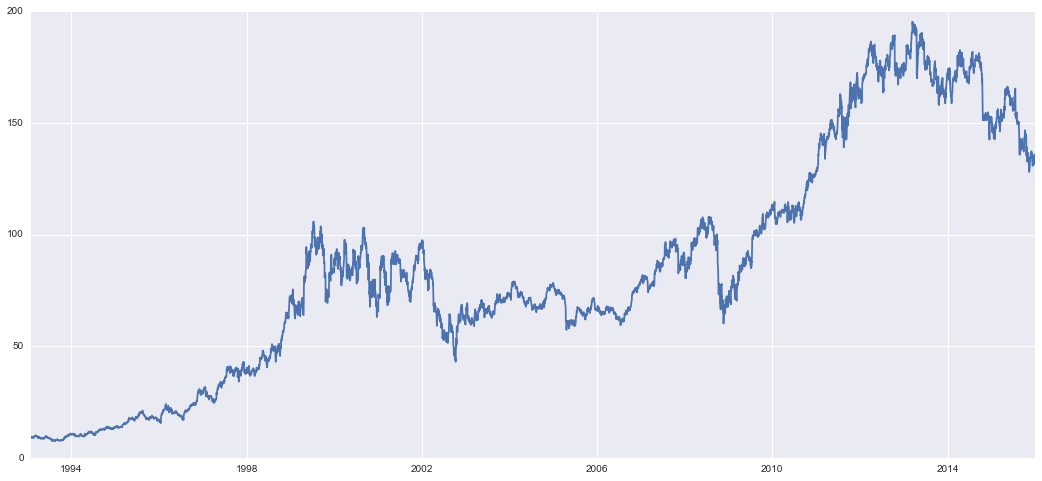

In [7]:
plt.plot(data)

In [144]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window=252):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window)
    rolstd = pd.rolling_std(timeseries, window)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    idx = timeseries.reset_index()
    for i in range(idx.shape[0]/window):
        plt.axvline(idx.ix[i*window]['Date'], color='g', linestyle='--', linewidth=0.5)
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

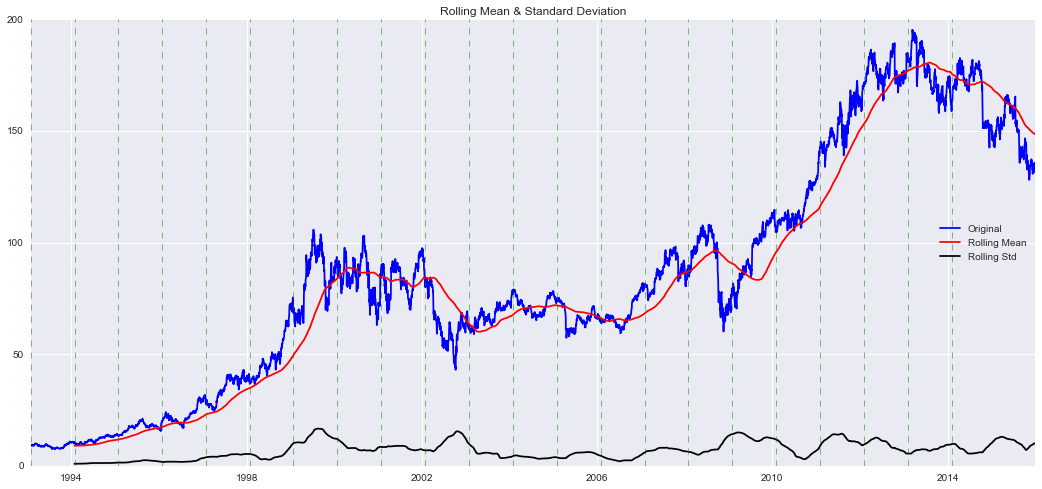

Results of Dickey-Fuller Test:
Test Statistic                   -1.255874
p-value                           0.649111
#Lags Used                       25.000000
Number of Observations Used    5749.000000
Critical Value (5%)              -2.862043
Critical Value (1%)              -3.431488
Critical Value (10%)             -2.567038
dtype: float64


In [145]:
ts = data
test_stationarity(ts, 252)

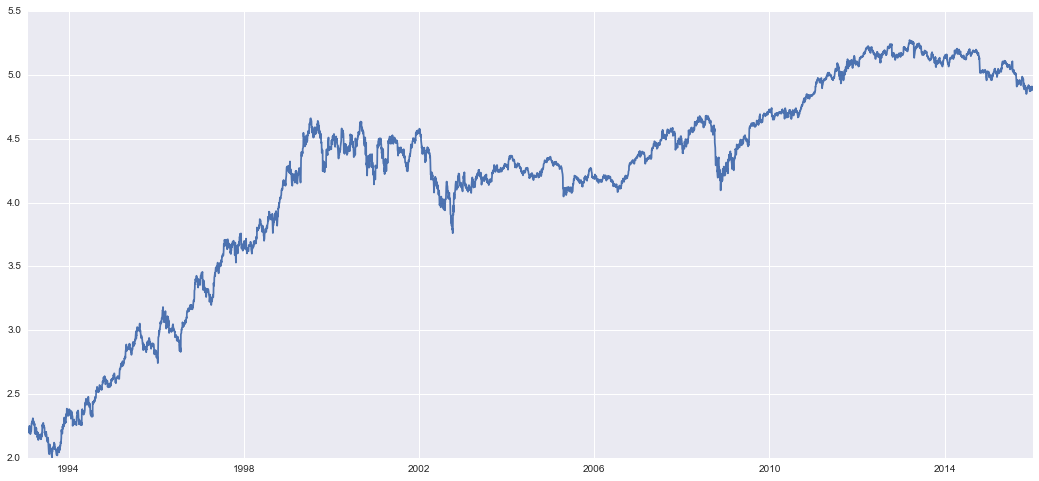

In [159]:
ts_log = np.log(ts)
plt.plot(ts_log)

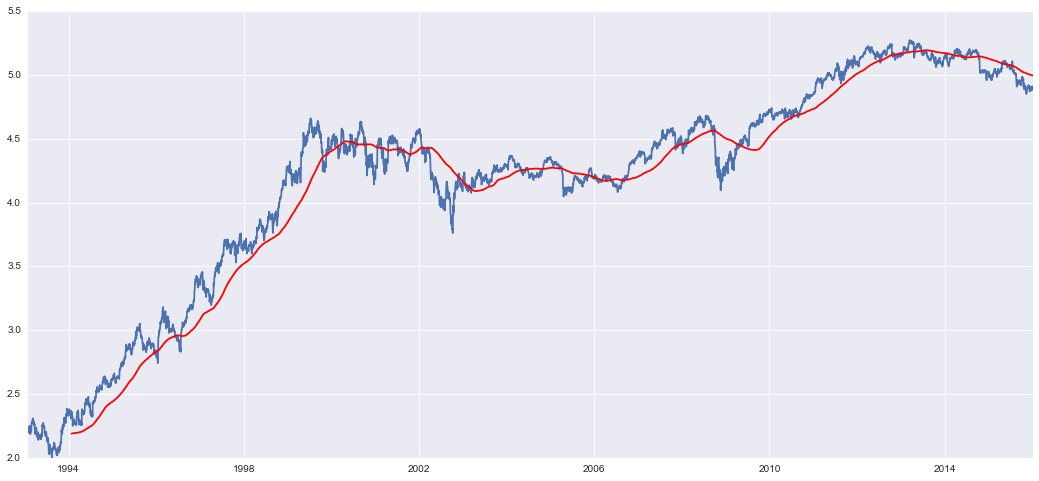

In [160]:
moving_avg = pd.rolling_mean(ts_log,252)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [161]:
ts_log = pd.rolling_mean(ts_log, window=252.0/4).dropna()
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(2)

Date
1993-01-29   NaN
1993-02-01   NaN
Name: IBM, dtype: float64

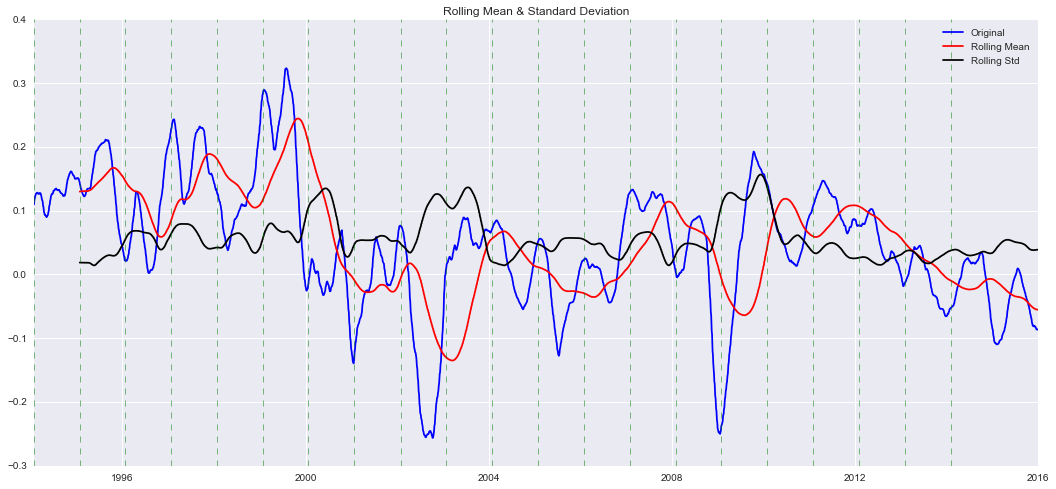

Results of Dickey-Fuller Test:
Test Statistic                   -5.509646
p-value                           0.000002
#Lags Used                       24.000000
Number of Observations Used    5499.000000
Critical Value (5%)              -2.862066
Critical Value (1%)              -3.431540
Critical Value (10%)             -2.567050
dtype: float64


In [162]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff, 252)

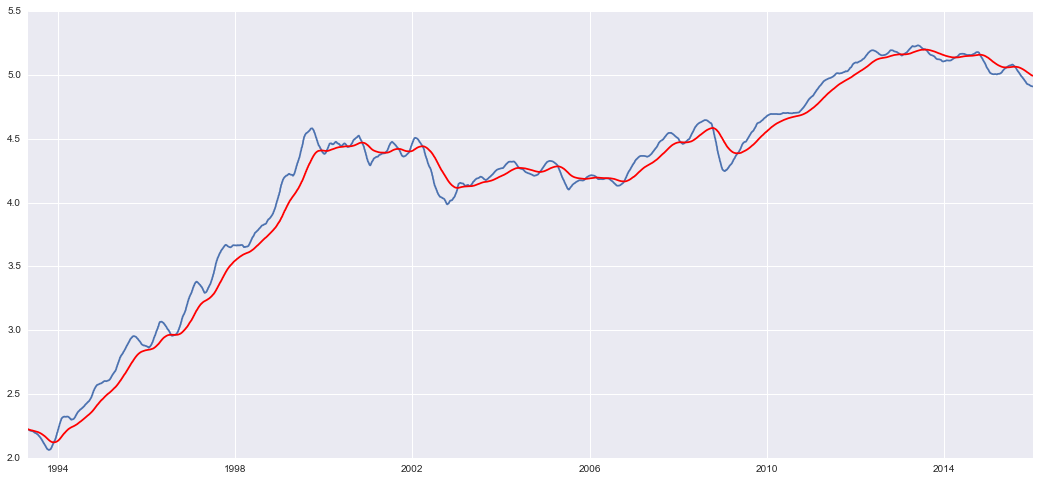

In [166]:
expwighted_avg = pd.ewma(ts_log, halflife=252/4)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

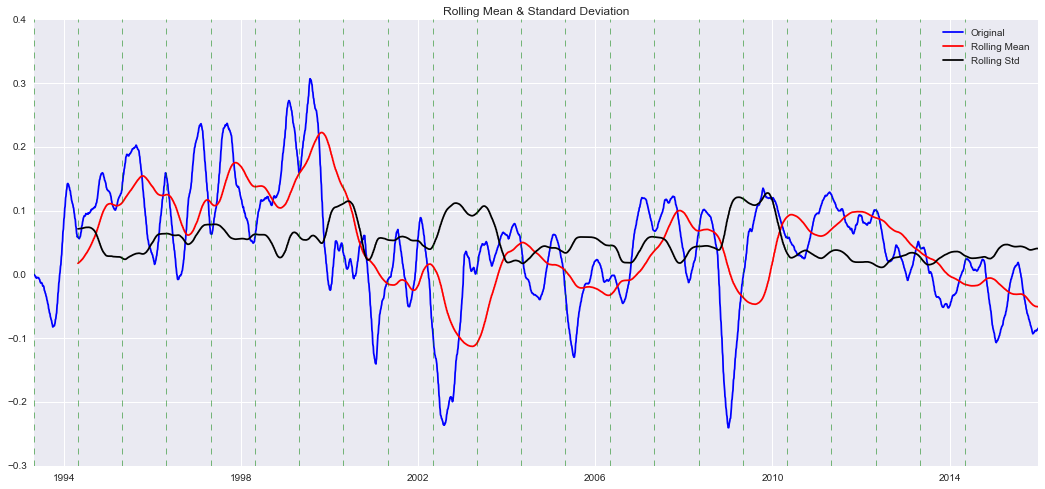

Results of Dickey-Fuller Test:
Test Statistic                   -5.607087
p-value                           0.000001
#Lags Used                       27.000000
Number of Observations Used    5685.000000
Critical Value (5%)              -2.862049
Critical Value (1%)              -3.431501
Critical Value (10%)             -2.567041
dtype: float64


In [168]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff, 252)

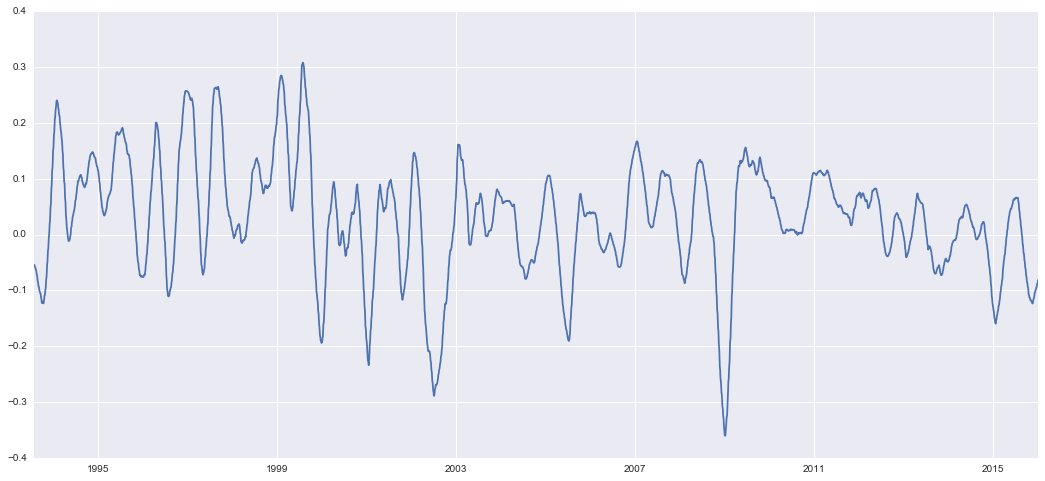

In [171]:
ts_log_diff = ts_log - ts_log.shift(252/4)
plt.plot(ts_log_diff)

In [172]:
import pyaudio
p = pyaudio.PyAudio()

volume = 0.5     # range [0.0, 1.0]
fs = 44100       # sampling rate, Hz, must be integer
duration = 1.0   # in seconds, may be float
f = 440.0        # sine frequency, Hz, may be float

# generate samples, note conversion to float32 array

val = ts_log_diff.dropna().transpose().values
val = np.array(map(lambda x: np.ones((50,))*x, val), dtype=float).flatten()
#samples = (np.sin(2*np.pi*np.arange(fs*duration)*f/fs)).astype(np.float32)
samples = (val).astype(np.float32)
print samples.shape

# for paFloat32 sample values must be in range [-1.0, 1.0]
stream = p.open(format=pyaudio.paFloat32,
                channels=1,
                rate=fs,
                output=True)

# play. May repeat with different volume values (if done interactively) 
stream.write(volume*samples)

stream.stop_stream()
stream.close()

p.terminate()


(282500L,)


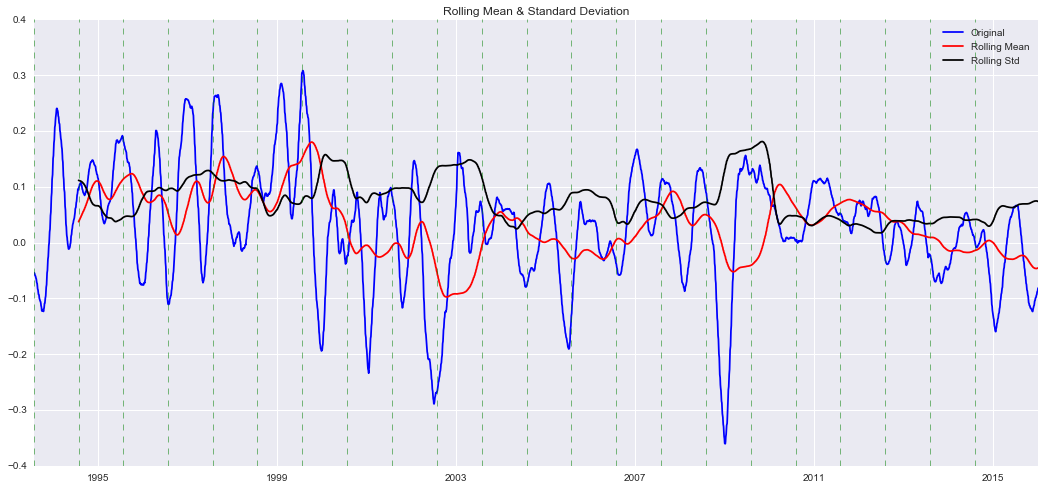

Results of Dickey-Fuller Test:
Test Statistic                -9.153387e+00
p-value                        2.649308e-15
#Lags Used                     2.700000e+01
Number of Observations Used    5.622000e+03
Critical Value (5%)           -2.862054e+00
Critical Value (1%)           -3.431514e+00
Critical Value (10%)          -2.567044e+00
dtype: float64


In [173]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff, 252)

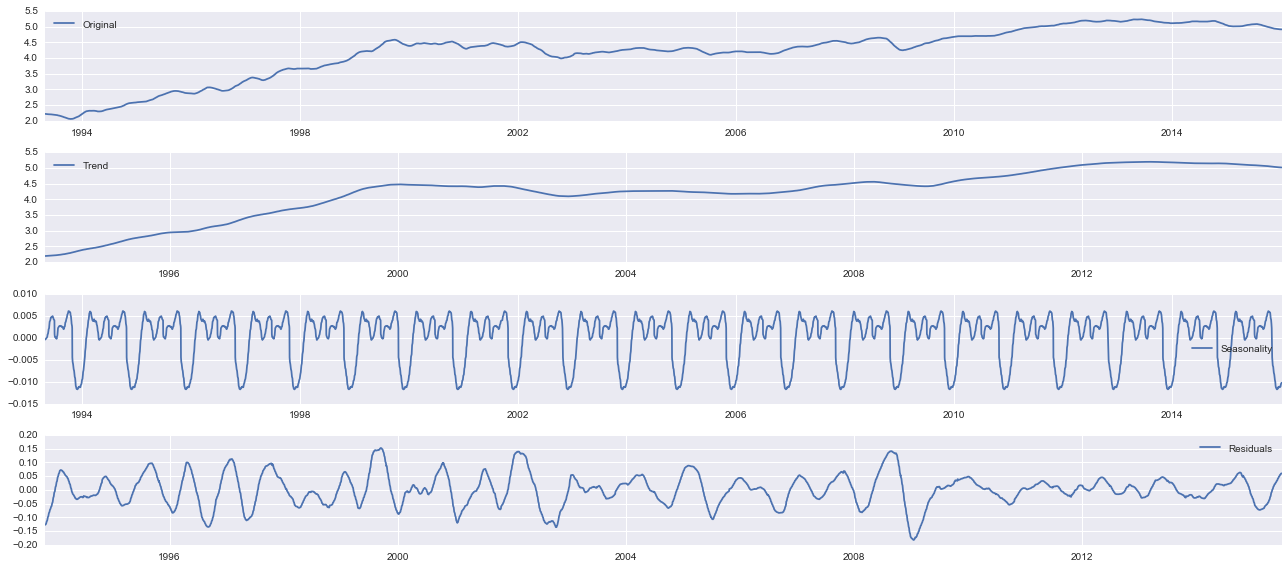

In [174]:
from statsmodels.tsa.seasonal import seasonal_decompose
#ts_log = pd.DataFrame({'IBM': ts_log.transpose().values}, index=ts_log.index)

decomposition = seasonal_decompose(ts_log2, freq=252)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

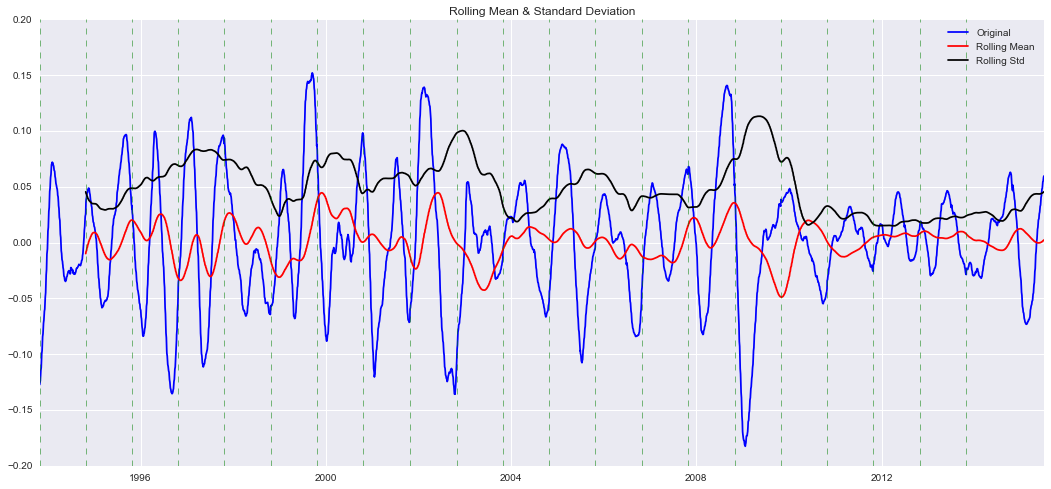

Results of Dickey-Fuller Test:
Test Statistic                -1.221415e+01
p-value                        1.145795e-22
#Lags Used                     2.500000e+01
Number of Observations Used    5.435000e+03
Critical Value (5%)           -2.862072e+00
Critical Value (1%)           -3.431554e+00
Critical Value (10%)          -2.567053e+00
dtype: float64


In [175]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose, 252)

In [176]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [183]:
lag_acf = acf(ts_log_diff, nlags=100)
lag_pacf = pacf(ts_log_diff, nlags=5, method='ols')

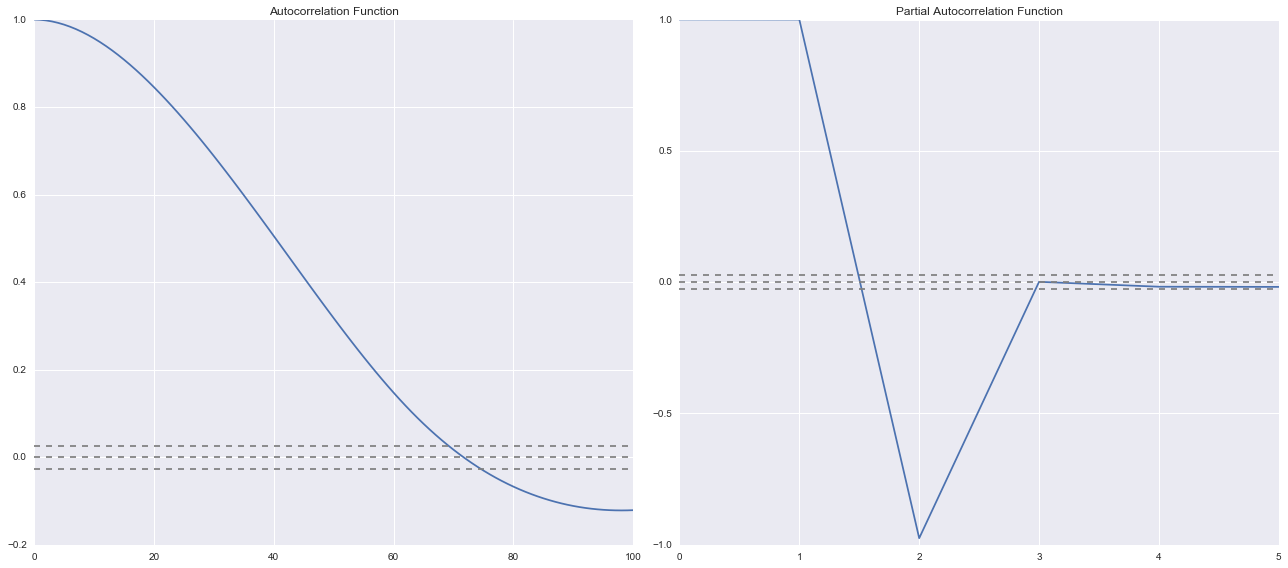

In [184]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [185]:
p = 2
q = 252/4
d = 70

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts_log2, order=(p, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

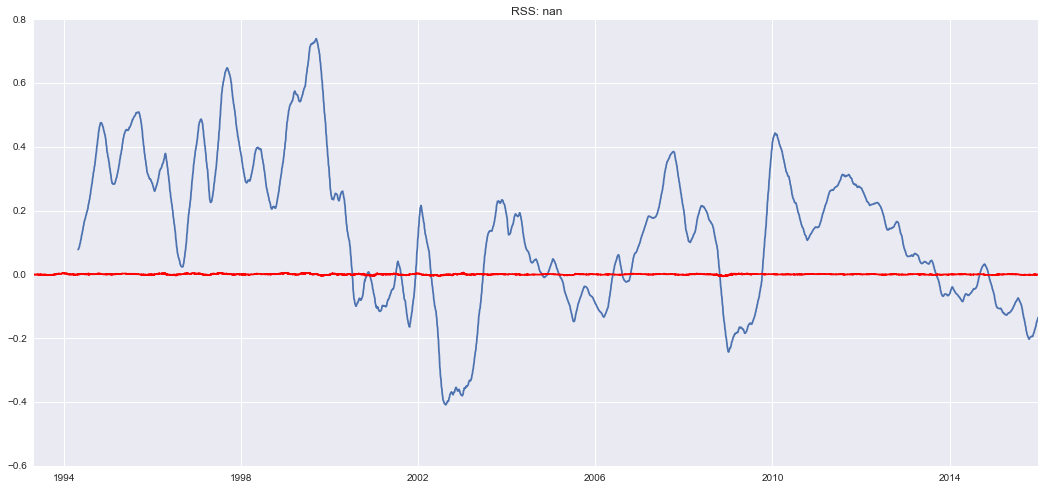

In [82]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

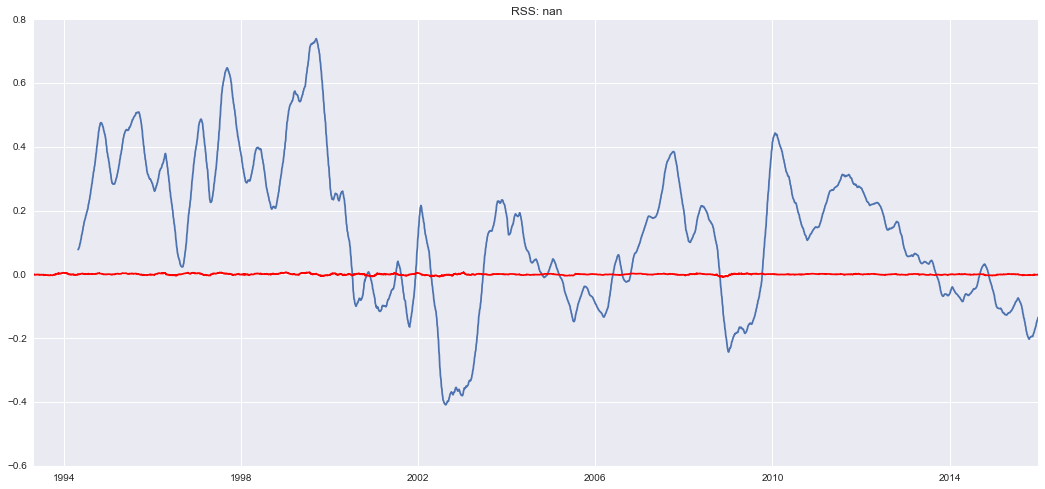

In [98]:
model = ARIMA(ts_log, order=(2, 1, 2), freq='Q')
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [134]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
pred_diff=results_ARIMA.predict('2015', '2016', dynamic=True)
print predictions_ARIMA_diff.head()
print pred_diff.head()

Date
1993-04-30    0.000449
1993-05-03   -0.000720
1993-05-04   -0.000858
1993-05-05   -0.000709
1993-05-06   -0.000367
dtype: float64
2015-12-31   -0.000464
2016-03-31   -0.000446
2016-06-30   -0.000429
2016-09-30   -0.000412
2016-12-31   -0.000395
Freq: Q-DEC, dtype: float64


In [138]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
pred_diff_cumsum = pred_diff.cumsum()
print predictions_ARIMA_diff_cumsum.head()
print pred_diff_cumsum.head()

Date
1993-04-30    0.000449
1993-05-03   -0.000271
1993-05-04   -0.001130
1993-05-05   -0.001838
1993-05-06   -0.002205
dtype: float64
2015-12-31   -0.000464
2016-03-31   -0.000910
2016-06-30   -0.001339
2016-09-30   -0.001750
2016-12-31   -0.002145
Freq: Q-DEC, dtype: float64


In [141]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
print predictions_ARIMA_log.head()

pred_log = pd.Series(ts_log.ix['2015'], index=ts_log.index).dropna()
pred_log = pred_log.add(pred_diff_cumsum,fill_value=0)
print pred_log.head()

Date
1993-04-29    2.222783
1993-04-30    2.223232
1993-05-03    2.222512
1993-05-04    2.221653
1993-05-05    2.220945
dtype: float64
2015-01-02    5.045491
2015-01-05    5.042934
2015-01-06    5.040000
2015-01-07    5.037245
2015-01-08    5.034521
dtype: float64


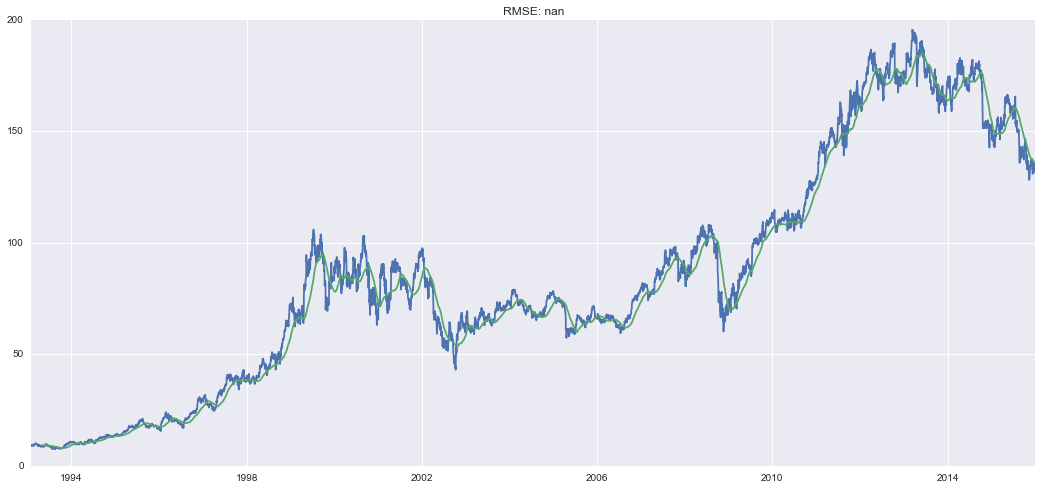

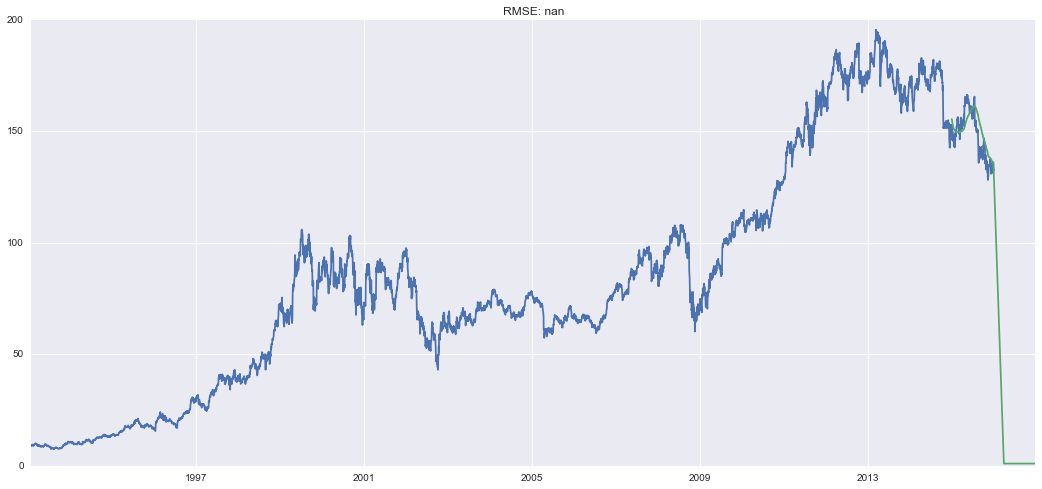

In [142]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))
plt.show()

pred_ARIMA = np.exp(pred_log)
plt.plot(ts)
plt.plot(pred_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((pred_ARIMA-ts)**2)/len(ts)))
plt.show()
